In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# **Jake's model**



In [ ]:
class JakesModel:
    def __init__(self, N, f_d):
        # Initial phases
        self.a_m = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        self.b_m = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        # Angle of arrivals
        self.aoa = np.arange(0, 2 * np.pi, 2 * np.pi / N).reshape(N, 1)  # No line of sight
        self.N = N
        self.f_d = f_d

    def get(self, t):
        # Keep in mind the numpy broadcasting rules!
        # https://numpy.org/doc/stable/user/basics.broadcasting.html
        re = np.cos(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.a_m)
        im = np.sin(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.b_m)
        return np.sum(re + 1j * im, axis=0) / np.sqrt(self.N)



# **Round Robbin Algorithm**

Using this algorithm we choose users consistently one by one in circular order. We get SNR from Jakes model and then for every slot we find the minimal value. This minimal value is average SNR for the slot. 

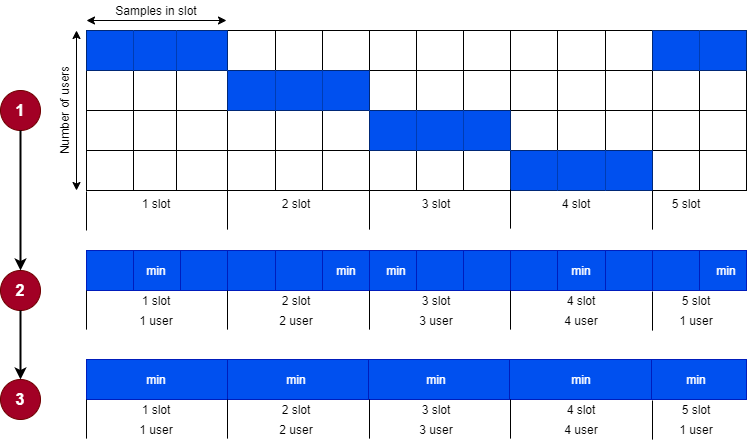

Picture 1. Schematic description of the Round Robbin algorithm.

Every cell is a sample.



In [ ]:
''' Function selects values from matrix with SNR for each user (step 1, Picture 1)
    according Round Robbin algorithm. Returns array with selected values
    (step 3, Picture 1)  '''
    

def roundRobin(SNR, n_samples_in_slot, n_all_samples, N_users):
    # New array for SNR values, thah will be given on the 3-rd step (Picture 1)
    ordered_SNR = np.array([])                                 

    # For all samples
    for i in range(n_all_samples):

        #calculate index for new array (nubmer of slots)
        newIndex = (i // n_samples_in_slot)

        #calculate index of current user (blue rows on 1st step of 1 Picture ) 
        index = (newIndex % N_users)

        # if new array contains value on newIndex position
        if ordered_SNR.shape[0] > newIndex:

            #if this value higher than current SNR value
            if ordered_SNR[newIndex] > SNR[index][i]:
                #Change value in array to min value  
                ordered_SNR[newIndex] = SNR[index][i] 
        # Add value to new array
        else:
            ordered_SNR = np.append(ordered_SNR,SNR[index][i])

    return ordered_SNR

# **Best condition algorithm**
In this algorithm we choose user with the highest SNR for slot and give him all the slot. Then for every slot we find the minimal value. Blue squares shows users with best conditions.

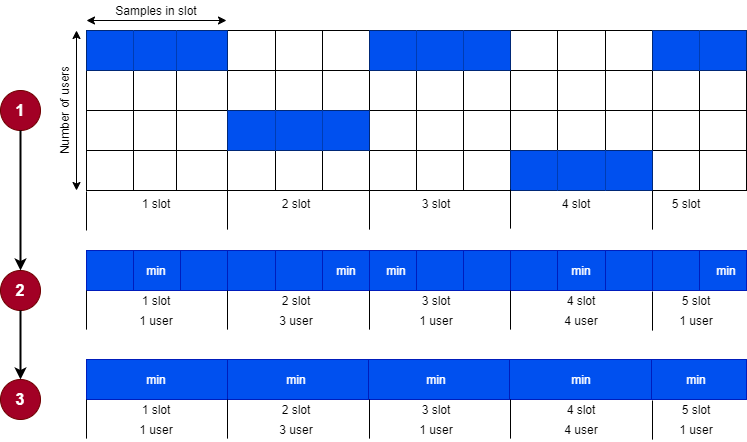

Picture 2. Schematic description of the Round Robbin algorithm

In [ ]:
''' Function selects values from matrix with SNR for each user (step 1, Picture 2)
    according best conditions algorithm. Returns array with selected values
    (step 3, Picture 2)  '''

def bestConditions(SNR, N_users, n_samples_in_slot, n_slots):
    # New array for SNR values, thah will be given on the 3-rd step (Picture 2)
    ordered_SNR = np.array([])

    # array contains indexes of users who had best conditons
    queue = np.array([])

    #For each slot
    for i in range(n_slots):
        #cut a slice of array that contains values for i-th slot
        _2D = SNR[:,i*n_samples_in_slot:i*n_samples_in_slot+n_samples_in_slot]
        
        # find index and column of the maximum SNR value in the slice
        m,n = np.unravel_index(_2D.argmax(), _2D.shape)
        # find index of minimal value in line that contains the maximal one
        n = np.argmin(_2D[m])
        
        # minimal SNR in channel with best conditions
        res = _2D[m][n]
        
        # save this min SNR 
        ordered_SNR = np.append(ordered_SNR , res)

        # save index of user, who has best conditions 
        queue = np.append(queue,m)

    return ordered_SNR, queue

# **Fairness index**
One of the simplest Fairness metrics is Jain's fairness index. This metric rates the fairness of a set of values where there are $n$ users and $x_i$ is the throughput for $i$th connection. (https://en.wikipedia.org/wiki/Fairness_measure)
$$
J(x_1,x_2,...,x_i)=\frac{(\sum_{i=1}^n{x_i})^2}{n{\sum_{i=1}^n{x_i^2}}}
$$

In [ ]:
#calculates fairness index
def getJainsIndex(x):
    return np.sum(x)**2/(x.size*np.sum(x**2))

# **Secondary functions**

In [ ]:
#calculates the sum of some quantity for each channel
def get_sum_per_channel(quantity, N_users, queue = None):
    # new array for averaged values
    sumValue = np.array([])
  
    # queue is None for Round Robbin algorithm
    if queue is None:
        
        #for each user
        for i in range(N_users):
            #calculate sum of the values sequentially in steps of N_users
            sumValue = np.append(sumValue, quantity[i::N_users].sum())
  
    #part for best channel condions algorithm
    else:
        # for each user
        for i in range(N_users):
            # find all values of i-th user
            ind = np.where(queue == i)
            # calculate sum for i-th user
            sum_for_user = sumOverArray(quantity,ind)
            # save the sum
            sumValue = np.append(sumValue,sum_for_user)

    return sumValue

# Calculate the sum of array values by array of indexes
def sumOverArray(arr , indexes):
    return arr[indexes].sum()
  

# **Model of experiment**

**Experiment's parameters**

In [ ]:
f_d = 0.1                # Doppler frequency [Hz]
n_paths = 100            # Number of paths in Jakes model

number_slots = 100          # Number of all slots
transmission_time = 1       # Transmission time [sec]
number_samples_in_slot = 10 # Number of samples in each slot

# Sampling period [sec]
sampling_period = transmission_time/number_samples_in_slot   

# Creating samples
t_samples = np.arange(0, number_slots, sampling_period)      

number_all_samples = t_samples.shape[0] # Number of all samples                        


**Experiment functions**

In [ ]:
''' Conduts an experimnet with given paramets.
    Calculates metrics for both methods - Round Robbin, Best channel condition
    Returns: 2 tuples with metrics. Each tuple contains of 
    - fairness index
    - averaged SE per user
    - amount data per user
    - throughput per user'''


def experiment(n_users):

    # Creating JakesModel for every user
    channels = [JakesModel(100, f_d) for i in range(n_users)]
 
    # Array for SNR
    SNR = np.array([])                                                       

    #for each user 
    for i in range(n_users):
        # Calculate current SNR in linear scale                                                   
        user_SNR = np.abs(channels[i].get(t_samples))**2
        # Save SNR in array 
        SNR = np.append(SNR , np.array(user_SNR))                         

    # Transposition of array to have data in rows
    SNR = SNR.reshape(n_users, -1)
    # Here we have data that shown on the first step of the both pictures


    '''Round robbin'''
    # We select SNR according Round Robbin algorithm.
    SNR_per_slot = roundRobin(SNR, number_samples_in_slot, number_all_samples, n_users)
    # Calculate metrics 
    robbin_res = calculate_metrics(SNR_per_slot, n_users)

    '''Best channel conditions'''
    # We select SNR according Best channel conditions algorithm.
    SNR_per_slot, queue = bestConditions(SNR, n_users, number_samples_in_slot,number_slots)
    # Calculate metrics 
    best_c_res = calculate_metrics(SNR_per_slot,n_users, queue)

    #return metrics
    return robbin_res, best_c_res

''' Conduts an experimnet with given paramets and AWGN.
    Calculates metrics for both methods - Round Robbin, Best channel condition
    Returns: 2 tuples with metrics. Each tuple contains of 
    - fairness index
    - averaged SE per user
    - amount data per user
    - throughput per user
    In this function we have fixed value for SNR'''

def experimentAWGN(n_users):

    # Create array SNR with fixed value (for example 3)  
    SNR = np.empty((t_samples.shape[0], n_users))
    SNR.fill(3)

    # Transposition of array to have data in rows
    SNR = SNR.reshape(n_users, -1)

    '''Round robbin'''
    # We select SNR according Round Robbin algorithm.
    SNR_per_slot = roundRobin(SNR, number_samples_in_slot,number_all_samples,n_users)
    # Calculate metrics 
    robbin_res = calculate_metrics(SNR_per_slot, n_users)

    '''Best channel conditions'''
    # We select SNR according Best channel conditions algorithm.
    SNR_per_slot, queue = bestConditions(SNR, n_users, number_samples_in_slot,number_slots)
    # Calculate metrics 
    best_c_res = calculate_metrics(SNR_per_slot,n_users, queue)
    
    #return metrics
    return robbin_res, best_c_res

In [ ]:
def calculate_metrics(SNR_per_slot, n_users, queue = None, isPrint = False):
    
    # Calculate Spectral Efficiency in slot [bit/(Hz*sec)]
    SE = np.log2(1 + SNR_per_slot) 

    # Calculate Bandwidth   [Hz]
    B = (1/sampling_period)

    # Calculate throughput in every slot    [bit/sec]
    C_slot = SE * B 

    # Calculate amount of information during the slot [bit]
    R_slot = C_slot*transmission_time           

    # Calculate amount of unformation for all slots [bit]
    R_sum = R_slot.sum()      

    # Calculate averaged throughput for all slots [bit/sec]
    C_avg = R_sum/(transmission_time*number_slots)                 

    # Calculate average user data rate over channels [bit]
    avg_R_ch = get_sum_per_channel(R_slot, n_users, queue)            

    # Calculate averaged spectral efficiency for all channels  [bit/(Hz*sec)]
    averageSE = np.mean(SE) 
    #averageSE =R_sum/(B*transmission_time)    



    # Calculate Fairness indexes                           
    jainsIndex = getJainsIndex(avg_R_ch)                                      

    if isPrint:
        print("Bandwidth    [Hz]          = ",B)
        print("Sum data     [bit]         = ",R_sum)
        print("Average SE   [bit/sec/Hz]  = ", averageSE)
        print("Average C    [bit/sec]     = ",C_avg)
        print("Fairness                   = ", jainsIndex)

    return jainsIndex, averageSE, R_sum, C_avg

In [ ]:
# Write data from tuple to array
def results_to_array(res: tuple, array):
    if array.size == 0:
       array = np.append(array, res)
    else:
        array = np.vstack((array,res))

    return array

# **Main Function**

In [ ]:
# Max numbers of users
max_users = 30

# Arrays for saving the resuls of each experiment
# They have 4 columns because we have 4 outout params from experiment
results_robbin_array = np.array([]).reshape(0,4)
results_best_c_array = np.array([]).reshape(0,4)

#For different number of users
for users in range(1,max_users):
    
    #buffers to store values that will be averaged
    buffer_robbin_array = np.array([])
    buffer_best_c_array = np.array([])
    
    # Number of repetitions of experiment with the same number of users
    for n_of_repetitions in range(15):
        
        #get parameters from experiment 
        robbin_res, best_c_res = experiment(users)

        #append the results to buffers
        buffer_robbin_array = results_to_array(robbin_res, buffer_robbin_array)
        buffer_best_c_array = results_to_array(best_c_res, buffer_best_c_array)

    # Save averaged values from buffers
    results_robbin_array = np.vstack((results_robbin_array, np.mean(buffer_robbin_array, axis = 0)))
    results_best_c_array = np.vstack((results_best_c_array, np.mean(buffer_best_c_array, axis = 0)))

# Transpose results for plotting
results_robbin_array = np.transpose(results_robbin_array)
results_best_c_array = np.transpose(results_best_c_array)

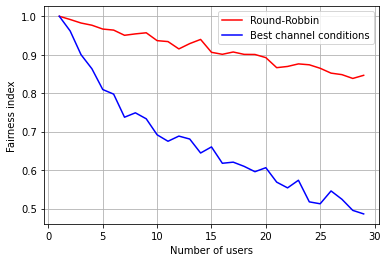

In [ ]:
plt.plot(np.arange(1,max_users), results_robbin_array[0], label = 'Round-Robbin', color = 'red')
plt.plot(np.arange(1,max_users), results_best_c_array[0], label = 'Best channel conditions', color = 'blue')
plt.grid()
plt.legend()
plt.ylabel('Fairness index')
plt.xlabel('Number of users')
plt.show()

As we can see, the Fairness index falls with the increase in the number of users. In Round Robbin case the Fairness tends to fluctuate around a constant level, because amount of data transefered by each user are rather constant. Nevertheless we can see that it slowly decreses. I think it's related with the fact that the more users we have the greater difference between transmitted  data. As for Best channel condition algoritm, we can see that Fairness decreses much faser. It's connected with the fact that with this algoritm we tends to have data from same users, who have best conditions and ignore chanels with worse conditions.

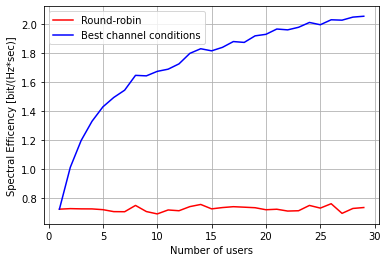

In [ ]:
plt.plot(np.arange(1,max_users), results_robbin_array[1],label= 'Round-robin', color = 'red' )
plt.plot(np.arange(1,max_users), results_best_c_array[1],label= 'Best channel conditions', color = 'blue')
plt.grid()
plt.legend()
plt.ylabel('Spectral Efficency [bit/(Hz*sec)]')
plt.xlabel('Number of users')
plt.show()

Here we can see the Specrtral Efficiency of both methods. For Round-Robbin have curve that fluctuate around the constant level. It's related with the fact that users usually transmit the same amount of data, because they have equal time intervals and they have equal conditions. 
As for Best channel conditions algorithm, we can see that spectral efficiency fastly increases about zero on the abscissa, and tends to be limited with abscissa increasing. That's because we tends to receive data from the same users who have best conditions, so they can transmit much more data then other. Nevertheless it have to be limited by channel capacity that tends to be changed by logarithmic law according Shannon-Hartley theorem.


Experiments with AWGN

In [ ]:
# Max numbers of users
max_users = 30

# Arrays for saving the resuls of each experiment
# They have 4 columns because we have 4 outout params from experiment
results_robbin_array = np.array([]).reshape(0,4)
results_best_c_array = np.array([]).reshape(0,4)

#For different number of users
for users in range(1,max_users):
    
    #buffers to store values that will be averaged
    buffer_robbin_array = np.array([])
    buffer_best_c_array = np.array([])
    
    # Number of repetitions of experiment with the same number of users
    for n_of_repetitions in range(2):
        
        #get parameters from experiment 
        robbin_res, best_c_res = experimentAWGN(users)

        #append the results to buffers
        buffer_robbin_array = results_to_array(robbin_res, buffer_robbin_array)
        buffer_best_c_array = results_to_array(best_c_res, buffer_best_c_array)

    # Save averaged values from buffers
    results_robbin_array = np.vstack((results_robbin_array, np.mean(buffer_robbin_array, axis = 0)))
    results_best_c_array = np.vstack((results_best_c_array, np.mean(buffer_best_c_array, axis = 0)))

# Transpose results for plotting
results_robbin_array = np.transpose(results_robbin_array)
results_best_c_array = np.transpose(results_best_c_array)

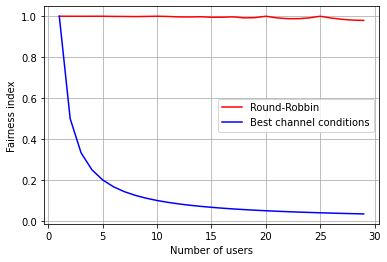

In [ ]:
plt.plot(np.arange(1,max_users), results_robbin_array[0], label = 'Round-Robbin', color = 'red')
plt.plot(np.arange(1,max_users), results_best_c_array[0], label = 'Best channel conditions', color = 'blue')
plt.grid()
plt.legend()
plt.ylabel('Fairness index')
plt.xlabel('Number of users')
plt.show()

This sutuation describes equality of received data in Round-Robbin algorithm, because all users tends to transmit the same amount of data.
As of Best channel conditions we have reverse situation. Because users have the same SNR value and we choses the same user.

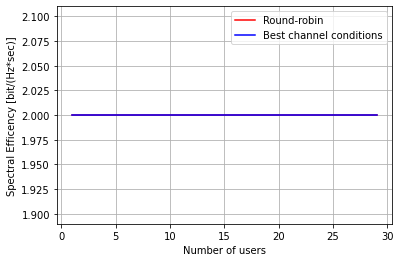

In [ ]:
plt.plot(np.arange(1,max_users), results_robbin_array[1],label= 'Round-robin', color = 'red' )
plt.plot(np.arange(1,max_users), results_best_c_array[1],label= 'Best channel conditions', color = 'blue')
plt.grid()
plt.legend()
plt.ylabel('Spectral Efficency [bit/(Hz*sec)]')
plt.xlabel('Number of users')
plt.show()

Spectral Efficiency are constant in case when SNR is fixed, because amount of received data is constant.  